# Experiments with real data (Students Performance)

https://archive.ics.uci.edu/dataset/320/student+performance


## Requirements

In [1]:
import os, pickle
import polars as pl
import numpy as np
from BigEDA.descriptive import outliers_table, summary
from BigEDA.plots import boxplot_matrix, histogram_matrix, barplot_matrix

current_path = os.getcwd()
data_path = os.path.join(current_path, '..', '..', '..', 'data')
data_filename = 'uci_students_performance_processed.pkl'
data_file_path = os.path.join(data_path, data_filename)

## Data exploration


### Conceptual description

| Variable   | Descripción                                                                 | Tipo                  | Justificación                                                                                      | Valores únicos |
|------------|-----------------------------------------------------------------------------|-----------------------|---------------------------------------------------------------------------------------------------|----------------|
| failures   | Número de asignaturas reprobadas previamente.                               | Numérica (entera)     | Refleja historial académico previo; alto valor suele asociarse a menor rendimiento futuro.         | 0, 1, 2, 3    |
| absences   | Número de ausencias a clase.                                                | Numérica (entera)     | La asistencia está directamente ligada al aprendizaje y a las calificaciones finales.              | 0 – 32        |
| studytime  | Tiempo de estudio semanal (categorías: 1–4).                                | Categórica ordinal    | Mide hábitos de estudio; más tiempo suele correlacionar con mejor rendimiento.                     | 1, 2, 3, 4    |
| schoolsup  | Apoyo educativo extra proporcionado por el colegio.                         | Binaria               | Representa recursos de refuerzo académico institucional.                                           | yes, no       |
| famsup     | Apoyo familiar en los estudios.                                             | Binaria               | El respaldo familiar influye en motivación y continuidad escolar.                                 | yes, no       |
| Medu       | Nivel educativo de la madre (0–4).                                          | Categórica ordinal    | La educación parental es un fuerte predictor del rendimiento académico de los hijos.              | 0, 1, 2, 3, 4|
| Fedu       | Nivel educativo del padre (0–4).                                            | Categórica ordinal    | Similar a `Medu`, añade contexto sociofamiliar relevante.                                          | 0, 1, 2, 3, 4|
| famrel     | Calidad de las relaciones familiares (1–5).                                 | Categórica ordinal    | Un entorno familiar estable favorece la concentración y el rendimiento escolar.                   | 1, 2, 3, 4, 5|
| goout      | Frecuencia de salidas con amigos (1–5).                                     | Categórica ordinal    | Exceso de ocio social puede competir con tiempo de estudio y afectar negativamente al rendimiento.| 1, 2, 3, 4, 5|
| Walc       | Consumo de alcohol en fines de semana (1–5).                                | Categórica ordinal    | Asociado a distracciones, menor rendimiento y problemas de salud que repercuten en los estudios.  | 1, 2, 3, 4, 5|
| health     | Estado de salud autoinformado (1–5).                                        | Categórica ordinal    | La salud condiciona la asistencia, la concentración y el rendimiento académico.                   | 1, 2, 3, 4, 5|
| G3         | Nota final del curso (0–20).                                                | Numérica (entera) (categorica ordinal, tras procesado)    | Variable objetivo a predecir, indicador del rendimiento académico global.                         | 0 – 20   ( ["suspenso", "suficiente", "bien", "notable", "sobresaliente"] tras transformarla a la escala 0 - 10 y categorizarla)    |


### Data reading

In [2]:
with open(data_file_path, "rb") as f:
    loaded_data = pickle.load(f)

X, y, p1, p2, p3, encoding, quant_predictors, binary_predictors, multiclass_predictors = loaded_data.values()

n_clusters = len(y.unique())

### Data view

In [3]:
X.head()

absences,failures,schoolsup,famsup,studytime,Medu,Fedu,famrel,goout,Walc,health
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
4,0,1,0,2,4,4,4,4,1,3
2,0,0,1,2,1,1,5,3,1,3
6,0,1,0,2,1,1,4,2,3,3
0,0,0,1,3,4,2,3,2,1,5
0,0,0,1,2,3,3,4,2,2,5


In [4]:
y.head(5)

G3_cat
i64
1
1
2
3
2


In [5]:
print(p1, p2, p3)

2 2 7


In [6]:
encoding

{'schoolsup': {'no': 0, 'yes': 1},
 'famsup': {'no': 0, 'yes': 1},
 'G3_cat': {'suspenso': 0,
  'suficiente': 1,
  'bien': 2,
  'notable': 3,
  'sobresaliente': 4}}

In [7]:
quant_predictors

['absences', 'failures']

In [8]:
binary_predictors

['schoolsup', 'famsup']

In [9]:
multiclass_predictors

['studytime', 'Medu', 'Fedu', 'famrel', 'goout', 'Walc', 'health']

### Data description

In [39]:
quant_summary, cat_summary = summary(df=X, quant_col_names = quant_predictors, cat_col_names = binary_predictors + multiclass_predictors)

In [40]:
quant_summary

,n_unique,perc_nan,mean,std,min,Q10,Q25,median,Q75,Q90,max,kurtosis,skew,prop_outliers
absences,24,0.0,3.659476,4.640759,0,0.0,0.0,2.0,6.0,10.0,32,8.727404,2.01602,0.032357
failures,4,0.0,0.22188,0.593235,0,0.0,0.0,0.0,0.0,1.0,3,12.739652,3.085546,0.154083


In [41]:
cat_summary

,n_unique,perc_nan,mode
schoolsup,2,0.0,0
famsup,2,0.0,1
studytime,4,0.0,2
Medu,5,0.0,2
Fedu,5,0.0,2
famrel,5,0.0,4
goout,5,0.0,3
Walc,5,0.0,1
health,5,0.0,5


In [42]:
quant_summary, cat_summary = summary(df=pl.DataFrame(y), cat_col_names = [y.name])

In [43]:
cat_summary

,n_unique,perc_nan,mode
G3_cat,5,0.0,1


In [44]:
# Proportion of individuals per cluster/group
unique_values, counts = np.unique(y, return_counts=True)
prop_clusters = counts/len(y)
prop_clusters = {k: v for k, v in zip(unique_values, prop_clusters)}
print(f'prop_clusters: {prop_clusters}')

prop_clusters: {0: 0.15408320493066255, 1: 0.30970724191063176, 2: 0.23728813559322035, 3: 0.2727272727272727, 4: 0.026194144838212634}


In [45]:
outliers_df = outliers_table(X, auto=False, col_names=quant_predictors, h=1.5)
outliers_df

quant_variables,lower_bound,upper_bound,n_outliers,n_not_outliers,prop_outliers,prop_not_outliers
str,f64,f64,i64,i64,f64,f64
"""absences""",-9.0,15.0,21,628,0.032357,0.967643
"""failures""",0.0,0.0,100,549,0.154083,0.845917


In [46]:
outliers_df['prop_outliers'].mean()

0.09322033898305085

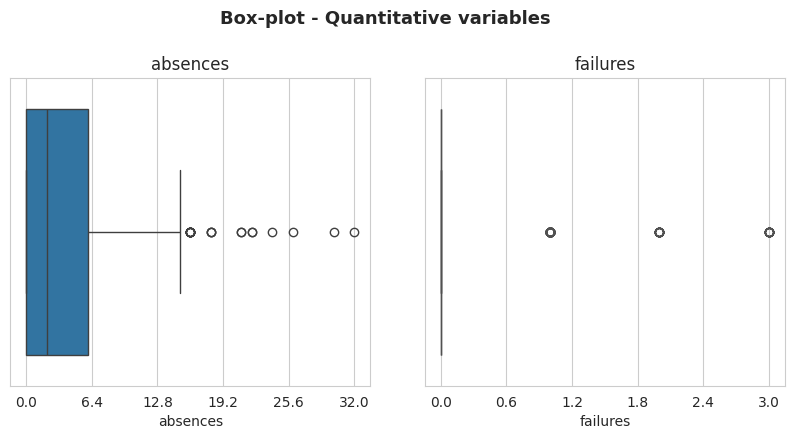

In [26]:
# Boxplot after outliers contamination
boxplot_matrix(X, 
               n_cols=2, 
               title='Box-plot - Quantitative variables', 
               figsize=(10,4), 
               quant_col_names=quant_predictors, 
               n_xticks=6, 
               title_fontsize=13, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=1.05,
               style='whitegrid', 
               hspace=0.7, 
               wspace=0.15, 
               title_weight='bold',
               subtitles_fontsize=12, 
               xlabel_size=10)

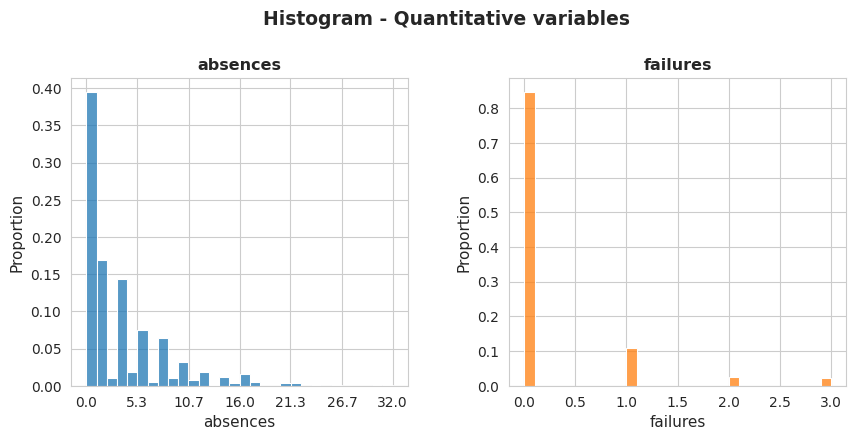

In [29]:
# Histogram
histogram_matrix(df=X, bins=30, n_cols=2, title='Histogram - Quantitative variables', 
                 figsize=(10,4), quant_col_names=quant_predictors, 
                 n_xticks=7, title_fontsize=13.5, 
                 subtitles_fontsize=11.5, save=False, file_name='', x_rotation=0, title_height=1.05,
                 style='whitegrid', hspace=0.5, wspace=0.3, n_round_xticks=1)

In [ ]:
# Barplot
barplot_matrix(df=X_pl, n_cols=2, title='Barplot - Categorical variables', 
                 figsize=(8,4), cat_col_names=['X5', 'X6', 'X7', 'X8'], 
                 title_fontsize=13, subtitles_fontsize=11, 
                 save=False, file_name='', x_rotation=0, title_height=0.99,
                 style='whitegrid', hspace=0.75, wspace=0.4, title_weight='bold', bar_width=0.35,
                 ylabel_size=10, xlabel_size=9, xticks_size=10)

In [ ]:
# Correlation Matrix
X.corr()

In [ ]:
# Correlation Analysis
corr_matrix = X.corr().to_numpy()
n_corr = len(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
n_corr_below_30 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) < 0.30)
n_corr_above_60 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) > 0.60)
n_corr_between = np.sum((np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) >= 0.30) & (np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) <= 0.60))
                        
print('Proportion of pair-wise correlation > 0.60 (in abs. value): ', np.round(n_corr_above_60 / n_corr, 2))
print('Proportion of pair-wise correlations in [0.30, 0.60]: ', np.round(n_corr_between / n_corr, 2))
print('Proportion of pair-wise correlation < 0.30 (in abs. value): ', np.round(n_corr_below_30 / n_corr, 2))


## Experiment 1



## Experiment 3



## Experiment 4